## README

- Data: https://www.kaggle.com/competitions/titanic/data
- My original GitHub notebook with markdown notes: [fastai/course22/05-linear-model-and-neural-net-from-scratch.ipynb](https://github.com/prasanth-ntu/fastai-course22/blob/master/05-linear-model-and-neural-net-from-scratch.ipynb)


## Introduction

In [272]:
import os
from pathlib import Path
import zipfile, kaggle

import torch, numpy as np, pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [273]:
from torch import tensor
import torch.nn.functional as F

from fastai.data.transforms import RandomSplitter

In [274]:
import sympy

In [275]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('../input/titanic')
else:
    competition_name = 'titanic'
    path = Path(f'../{competition_name}')
    if not path.exists():
        kaggle.api.competition_download_cli(competition=competition_name, path = '../')
        zipfile.ZipFile(f'{path}.zip').extractall(path)
    else:
        print (f"path: '{path}' exists")
print (f"Files: {os.listdir(path)}")

path: '../titanic' exists
Files: ['test.csv', 'train.csv', 'gender_submission.csv', 'sub.csv']


In [276]:
print (f"Default | numpy > printoptions > linewidth: {np.get_printoptions()['linewidth']}")
print (f"Default | pandas > display.width: {pd.get_option('display.width')}")
print (f"Default | pytorch > printoptions > linewidth: {80}")

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

Default | numpy > printoptions > linewidth: 140
Default | pandas > display.width: 140
Default | pytorch > printoptions > linewidth: 80


## Cleaning the data

In [277]:
df = pd.read_csv(f"{path}/train.csv")
print (df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [278]:
# check for missing values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [279]:
# Replace missing values by using mode!
# Note: There are better approaches, but let's keep it simple for start
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [280]:
df.fillna(value=modes, inplace=True)

In [281]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [282]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [283]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [284]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype='object')

In [285]:
# Let's preprocess the following features
['Age', 'SibSp', 'Parch'] # Continuous: No processing (as SibSp and Parch are ordinal)
['Fare'] # Continuous: Fix long tail data distribution issue
['Pclass', 'Sex', 'Embarked'] # Categorial: Generate dummy variables (as they are categorical) for nominal

['Pclass', 'Sex', 'Embarked']

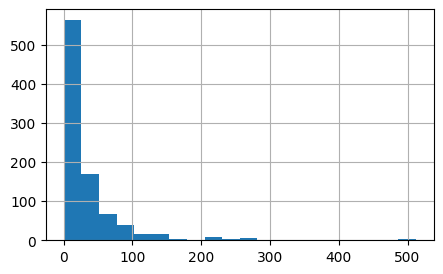

In [286]:
df['Fare'].hist(figsize=(5,3), bins=20);

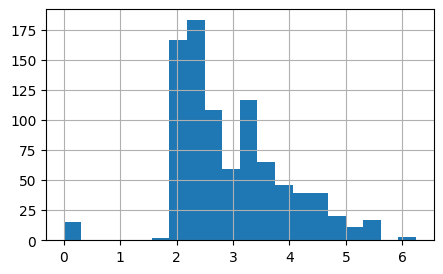

In [287]:
# Taking log to solve the skewness in the data to make it more uniformly distributed
df['LogFare'] = np.log(df['Fare']+1) # +1 to handle log(0) error as some Fare values are 0.
df['LogFare'].hist(figsize=(5,3), bins=20);

The 3 'Pclass' are [1, 2, 3]


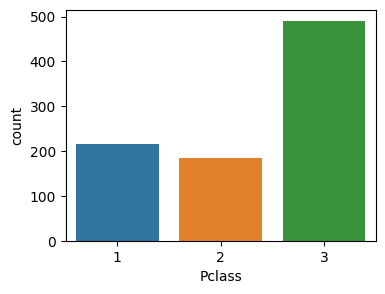

In [288]:
pclasses = sorted(df['Pclass'].unique())
print (f"The {len(pclasses)} 'Pclass' are {pclasses}")
plt.figure(figsize=(4,3))
sns.countplot(df, x='Pclass');

The 3 'Embarked' places are ['C', 'Q', 'S']


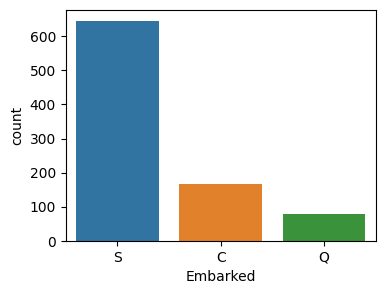

In [289]:
embarked_places = sorted(df['Embarked'].unique())
print (f"The {len(embarked_places)} 'Embarked' places are {embarked_places}")
plt.figure(figsize=(4,3))
sns.countplot(df, x='Embarked');

The 'Sex' vlaues are ['male' 'female']


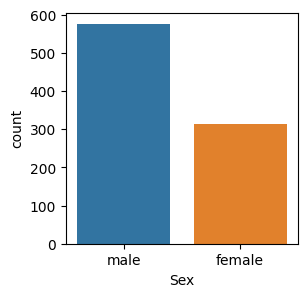

In [290]:
print (f"The 'Sex' vlaues are {df['Sex'].unique()}")
plt.figure(figsize=(3,3))
sns.countplot(df, x='Sex');

In [291]:
# Add dummy variables as additional cols
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [292]:
added_cols = ['Sex_male', 'Sex_female',
              'Pclass_1', 'Pclass_2', 'Pclass_3', 
              'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head(2)

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,True,False,False,False,True,False,False,True
1,False,True,True,False,False,True,False,False


In [293]:
# Create dependent variable as Rank 1 Tensor
t_dep = tensor(df['Survived'])
print (f"Shape: {t_dep.shape}") # 1D data
print (f"Rank : {len(t_dep.shape)}")
print (t_dep[:10])

Shape: torch.Size([891])
Rank : 1
tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])


In [294]:
# Create dependent variables as a Rank 2 Tensor
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values.astype(float), dtype=torch.float) # torch.float == torch.float32
print (f"Shape: {t_indep.shape}") # 2D data
print (f"Rank : {len(t_indep.shape)}")
print (t_indep[:2])

Shape: torch.Size([891, 12])
Rank : 2
tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000]])


## Setting up a linear model

In [295]:
torch.manual_seed(442)

# Create initial coefficients for our linear model
n_coeffs = t_indep.shape[1]
coeffs = torch.rand(n_coeffs) - 0.5
print (f"{coeffs.shape}")
coeffs

torch.Size([12])


tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [296]:
# y_pred = w1x1 + w2x2 + ... + wnxn
# Lets compute the [w1x1 w2x2 ... wnxn] as a matrix
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [297]:
# Problem: Since some feature cols (esp. Age) are of high magnitude, they would dominate the other cols
# Solution: Divide all the feature cols by their max (primitive approach), so max value will be 1

vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals # (Auto-) Broadcasting vector into matrix for division across all rows

In [298]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [299]:
preds = (t_indep*coeffs).sum(dim=1)
print (preds.shape)
preds[:10]

torch.Size([891])


tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

In [300]:
# define loss function as MAE (to do gradient descent to optimize weights, we need loss function)
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5382)

In [301]:
def calc_preds(coeffs, indeps):
    preds = (indeps*coeffs).sum(axis=1)
    return preds

def calc_loss(coeffs, indeps, deps):
    preds = calc_preds(coeffs, indeps)
    loss = torch.abs(preds - deps).mean()
    return loss

## Doing a gradient descent step

In [302]:
# Enable tracking in computational graph (so that PyTorch compute gradients during backprop)
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [303]:
# Calculate loss (and PyTorch will keep track of all the steps so that PyTorch compute gradients during backprop)
loss = calc_loss(coeffs=coeffs, indeps=t_indep, deps=t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

In [304]:
loss.backward()

In [305]:
# A negative grad implies that the coefficient needs to be increased and viceversa
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

In [306]:
# Each time when we call loss.backward(), the gradients are added to coeffs.grad attribute value
loss = calc_loss(coeffs=coeffs, indeps=t_indep, deps=t_dep)
print (loss)
loss.backward()
coeffs.grad 

tensor(0.5382, grad_fn=<MeanBackward0>)


tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

In [307]:
# So, we need to set the coeffs.grad after using the gradients to do a gradient descent step

In [308]:
# Let's do one gradient step and see whether the loss decreases

coeffs.grad.zero_()
loss = calc_loss(coeffs=coeffs, indeps=t_indep, deps=t_dep)
loss.backward()

with torch.no_grad(): # disabled gradient calculation
    coeffs = coeffs.sub_(other=0.1 * coeffs.grad) # coeff = coeff - learning_rate*gradient
    coeffs.grad.zero_()
    loss = calc_loss(coeffs=coeffs, indeps=t_indep, deps=t_dep)    
    print (loss)

tensor(0.5197)


In [309]:
# The loss value has decreased from 0.5382 to 0.5197 after one gradient descent step

## Training the linear model

In [310]:
# Split data into train and valid sets

# Get indices for trn and val split
trn_split_indices, val_split_indices = RandomSplitter(seed=42)(df)
print (len(trn_split_indices), len(val_split_indices))
print (trn_split_indices[:5], val_split_indices[:5])

713 178
[788, 525, 821, 253, 374] [303, 778, 531, 385, 134]


In [311]:
# apply the indices to our indep and dep var
trn_indep, val_indep = t_indep[trn_split_indices], t_indep[val_split_indices]
trn_dep, val_dep = t_dep[trn_split_indices], t_dep[val_split_indices]
print (len(trn_indep), len(val_indep))

713 178


In [312]:
# create fns for updating coeffs, doing one full grad desc step, and init coefs
def init_coeffs(n_coeffs):
    coeffs = torch.rand(n_coeffs) - 0.5
    coeffs.requires_grad_()
    return coeffs

def update_coeffs(coeffs, lr):
    coeffs.sub_(lr*coeffs.grad)
    return coeffs.grad.zero_()
    
def one_epoch(coeffs, lr, indeps, deps):
    loss = calc_loss(coeffs, indeps, deps)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    return coeffs, loss

In [313]:
def train_model(n_coeffs, indeps, deps, epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs(n_coeffs)
    for i in range(epochs):
        coeffs, loss = one_epoch(coeffs, lr, indeps, deps)
        # Print loss after every gradient descent update step for each epoch
        print (f"i={i:>3d} | loss={loss:>5.3f}")
    return coeffs

In [314]:
# Loss should decrease after every epoch
coeffs = train_model(n_coeffs=n_coeffs, indeps=trn_indep, deps=trn_dep, epochs=18, lr=0.2)

i=  0 | loss=0.536
i=  1 | loss=0.502
i=  2 | loss=0.477
i=  3 | loss=0.454
i=  4 | loss=0.431
i=  5 | loss=0.409
i=  6 | loss=0.388
i=  7 | loss=0.367
i=  8 | loss=0.349
i=  9 | loss=0.336
i= 10 | loss=0.330
i= 11 | loss=0.326
i= 12 | loss=0.329
i= 13 | loss=0.304
i= 14 | loss=0.314
i= 15 | loss=0.296
i= 16 | loss=0.300
i= 17 | loss=0.289


In [315]:
coeffs

tensor([-0.2694,  0.0901,  0.2359,  0.0280, -0.3990,  0.2345,  0.7232,  0.4112,  0.3601,  0.0955,  0.2395,  0.2122], requires_grad=True)

In [316]:
# Turn off requires_grad_ to False as training is completed, and we will only do inference
coeffs.requires_grad_(False)

tensor([-0.2694,  0.0901,  0.2359,  0.0280, -0.3990,  0.2345,  0.7232,  0.4112,  0.3601,  0.0955,  0.2395,  0.2122])

In [317]:
def show_coeffs(coeffs, indep_cols):
    return dict(zip(indep_cols, coeffs.numpy()))
show_coeffs(coeffs, indep_cols)

{'Age': -0.26935664,
 'SibSp': 0.090121895,
 'Parch': 0.2359452,
 'LogFare': 0.027992353,
 'Sex_male': -0.3990123,
 'Sex_female': 0.2345131,
 'Pclass_1': 0.7232336,
 'Pclass_2': 0.4111845,
 'Pclass_3': 0.36010766,
 'Embarked_C': 0.09548305,
 'Embarked_Q': 0.23946138,
 'Embarked_S': 0.2121628}

## Measuring accuracy

In [318]:
preds = calc_preds(coeffs, indeps=val_indep)

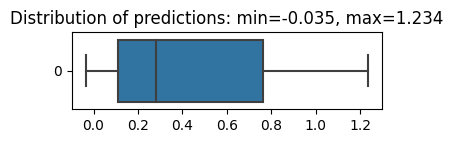

In [319]:
plt.figure(figsize=(4,1))
sns.boxplot(data=preds.numpy(), orient='h');
plt.title(f"Distribution of predictions: min={preds.min():.3f}, max={preds.max():.3f}");

In [320]:
results = (val_dep == (preds>0.5))
results[:5]

tensor([True, True, True, True, True])

In [321]:
results.float().mean() # Accuracy

tensor(0.7865)

In [322]:
def calc_acc(coeffs, indeps, deps):
    preds = calc_preds(coeffs, indeps)
    results = (val_dep == (preds>0.5)).float().mean()
    return results

calc_acc(coeffs=coeffs, indeps=val_indep, deps=val_dep)

tensor(0.7865)

## Using sigmoid

In [323]:
# Problem: The pred outputs of survival are bounded within - and 1.
# Solution: Use sigmoid to force the outputs to be between 0 and 1

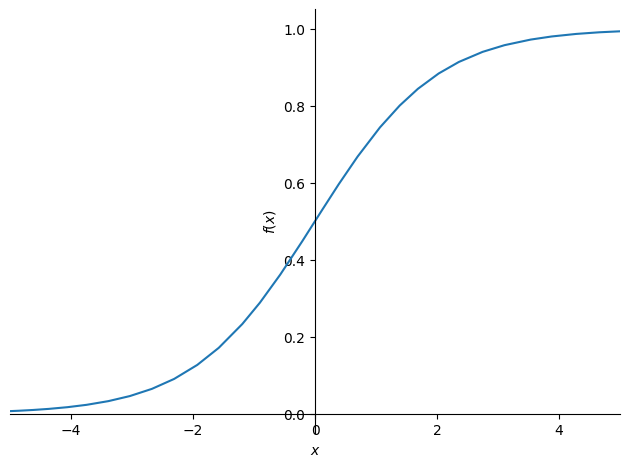

In [324]:
sympy.plot("1/(1+exp(-x))", xlim=(-5, 5), figsize=(3,2))

In [325]:
# Modify the function using pytorch sigmoid function
def calc_preds(coeffs, indeps):
    preds = torch.sigmoid((indeps*coeffs).sum(axis=1))
    return preds

In [326]:
coeffs = train_model(n_coeffs=n_coeffs, indeps=trn_indep, deps=trn_dep, epochs=30, lr=100)

i=  0 | loss=0.510
i=  1 | loss=0.327
i=  2 | loss=0.294
i=  3 | loss=0.207
i=  4 | loss=0.201
i=  5 | loss=0.199
i=  6 | loss=0.198
i=  7 | loss=0.197
i=  8 | loss=0.196
i=  9 | loss=0.196
i= 10 | loss=0.196
i= 11 | loss=0.195
i= 12 | loss=0.195
i= 13 | loss=0.195
i= 14 | loss=0.195
i= 15 | loss=0.195
i= 16 | loss=0.195
i= 17 | loss=0.195
i= 18 | loss=0.194
i= 19 | loss=0.194
i= 20 | loss=0.194
i= 21 | loss=0.194
i= 22 | loss=0.194
i= 23 | loss=0.194
i= 24 | loss=0.194
i= 25 | loss=0.194
i= 26 | loss=0.194
i= 27 | loss=0.194
i= 28 | loss=0.194
i= 29 | loss=0.194


In [327]:
calc_acc(coeffs, indeps=val_indep, deps=val_dep)

tensor(0.8258)

In [328]:
# Both loss and accuracy has got better with sigmoid in the preds
coeffs.requires_grad_(False)
show_coeffs(coeffs, indep_cols)

{'Age': -1.506051,
 'SibSp': -1.1574632,
 'Parch': -0.42667046,
 'LogFare': 0.2542521,
 'Sex_male': -10.332026,
 'Sex_female': 8.418526,
 'Pclass_1': 3.8388915,
 'Pclass_2': 2.1397836,
 'Pclass_3': -6.233148,
 'Embarked_C': 1.4771262,
 'Embarked_Q': 2.116762,
 'Embarked_S': -4.79578}

## Submitting to Kaggle

In [329]:
tst_df = pd.read_csv(f'{path}/test.csv')
print (tst_df.shape)
tst_df.head(2)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [330]:
tst_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [331]:
tst_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [332]:
# Preprocessing
tst_df.fillna(value=modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=['Sex', 'Pclass', 'Embarked'])

tst_indep = tensor(tst_df[indep_cols].values.astype(float), dtype=torch.float)
tst_indep = tst_indep/vals

In [333]:
tst_indep[:5] # Sanity check

tensor([[0.4313, 0.0000, 0.0000, 0.3490, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.5875, 0.1250, 0.0000, 0.3332, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.7750, 0.0000, 0.0000, 0.3796, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 0.3634, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.2750, 0.1250, 0.1667, 0.4145, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]])

In [334]:
tst_df['Survived'] = (calc_preds(coeffs, indeps=tst_indep)>0.5).int() # Kaggle expects the preds as int dtype
tst_df['Survived'].head(2)

0    0
1    0
Name: Survived, dtype: int32

In [335]:
# Kaggle competition expects the submission in specific .csv format
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv(f'{path}/sub.csv')
sub_df.head(2)

,PassengerId,Survived
0,892,0
1,893,0


In [336]:
!head '../sub.csv'

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## Using matrix product

In [262]:
# For inner-most calculation of 'w_1x_1 + ... w_nx_n', 
# we can use PyTorch @ operator to indicate matrix products as they are highly optimized

In [341]:
%%timeit -n 100
(val_indep*coeffs).sum(axis=1)

The slowest run took 5.66 times longer than the fastest. This could mean that an intermediate result is being cached.
23.5 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [343]:
%%timeit -n 100
val_indep@coeffs

The slowest run took 4.83 times longer than the fastest. This could mean that an intermediate result is being cached.
7.39 µs ± 4.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [344]:
# Sanity checks
print(((val_indep*coeffs).sum(axis=1)).shape, (val_indep@coeffs).shape)

torch.Size([178]) torch.Size([178])


In [346]:
print ((val_indep*coeffs).sum(axis=1)[:5])
print ((val_indep@coeffs)[:5])

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511])
tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511])


In [347]:
def calc_preds(coeffs, indeps):
    preds = torch.sigmoid((indeps@coeffs)) #.sum(axis=1))
    return preds

In [348]:
# To do matrix-matrix products (which we will need in next NN section)
# Turn our coeffs into a col vector (matrix with single cols a.k.a Rank 2 matrix)
def init_coeffs(n_coeffs):
    coeffs = torch.rand(n_coeffs, 1) - 0.5
    return coeffs.requires_grad_() 

In [349]:
# Also. need to turn our dep variables into Rank 2 matrix
print (f"Before: {trn_dep.shape}, {val_dep.shape}")
trn_dep = trn_dep[:, None]
val_dep = val_dep[:, None]
print (f"After: {trn_dep.shape}, {val_dep.shape}")

Before: torch.Size([713]), torch.Size([178])
After: torch.Size([713, 1]), torch.Size([178, 1])


In [350]:
coeffs = train_model(n_coeffs=n_coeffs, indeps=trn_indep, deps=trn_dep, epochs=30, lr=100)

i=  0 | loss=0.510
i=  1 | loss=0.327
i=  2 | loss=0.294
i=  3 | loss=0.207
i=  4 | loss=0.201
i=  5 | loss=0.199
i=  6 | loss=0.198
i=  7 | loss=0.197
i=  8 | loss=0.196
i=  9 | loss=0.196
i= 10 | loss=0.196
i= 11 | loss=0.195
i= 12 | loss=0.195
i= 13 | loss=0.195
i= 14 | loss=0.195
i= 15 | loss=0.195
i= 16 | loss=0.195
i= 17 | loss=0.195
i= 18 | loss=0.194
i= 19 | loss=0.194
i= 20 | loss=0.194
i= 21 | loss=0.194
i= 22 | loss=0.194
i= 23 | loss=0.194
i= 24 | loss=0.194
i= 25 | loss=0.194
i= 26 | loss=0.194
i= 27 | loss=0.194
i= 28 | loss=0.194
i= 29 | loss=0.194


In [351]:
# The accuracy and loss are similar to previous results
calc_acc(coeffs=coeffs, indeps=val_indep, deps=val_dep)

tensor(0.8258)

## Neural Network

In [373]:
def init_coeffs(n_coeffs, n_hidden=20):
    # For layer 1, we do not need const term as we are using 'n' dummy variables
    # Dividing layer1 coeffs by n_hidden so that when we sum up in next layer, we will end up with similar magnitude
    layer1 = (torch.rand(n_coeffs, n_hidden)-0.5)/n_hidden
    layer1.requires_grad_()
    # For layer 2, we need constant term
    layer2 = (torch.rand(n_hidden,1)-0.3) # 0.3 is chosed by trial and error
    const2 = torch.rand(1)
    layer2.requires_grad_()
    const2.requires_grad_()
    return layer1, layer2, const2

In [374]:
def calc_preds(coeffs, indeps):
    l1, l2, const2 = coeffs
    res = F.relu(indeps@l1)
    res = F.sigmoid((res@l2) + const2)
    return res

In [375]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(lr * layer.grad)
        layer.grad.zero_()
    return coeffs

In [376]:
coeffs = train_model(n_coeffs=n_coeffs, indeps=trn_indep, deps=trn_dep, epochs=30, lr=1.4)

i=  0 | loss=0.543
i=  1 | loss=0.532
i=  2 | loss=0.520
i=  3 | loss=0.505
i=  4 | loss=0.487
i=  5 | loss=0.466
i=  6 | loss=0.439
i=  7 | loss=0.407
i=  8 | loss=0.373
i=  9 | loss=0.343
i= 10 | loss=0.319
i= 11 | loss=0.301
i= 12 | loss=0.286
i= 13 | loss=0.274
i= 14 | loss=0.264
i= 15 | loss=0.256
i= 16 | loss=0.250
i= 17 | loss=0.245
i= 18 | loss=0.240
i= 19 | loss=0.237
i= 20 | loss=0.234
i= 21 | loss=0.231
i= 22 | loss=0.229
i= 23 | loss=0.227
i= 24 | loss=0.226
i= 25 | loss=0.224
i= 26 | loss=0.223
i= 27 | loss=0.222
i= 28 | loss=0.221
i= 29 | loss=0.220


In [378]:
coeffs = train_model(n_coeffs=n_coeffs, indeps=trn_indep, deps=trn_dep, epochs=30, lr=20)

i=  0 | loss=0.543
i=  1 | loss=0.400
i=  2 | loss=0.260
i=  3 | loss=0.390
i=  4 | loss=0.221
i=  5 | loss=0.211
i=  6 | loss=0.197
i=  7 | loss=0.195
i=  8 | loss=0.193
i=  9 | loss=0.193
i= 10 | loss=0.193
i= 11 | loss=0.193
i= 12 | loss=0.193
i= 13 | loss=0.193
i= 14 | loss=0.193
i= 15 | loss=0.193
i= 16 | loss=0.193
i= 17 | loss=0.192
i= 18 | loss=0.192
i= 19 | loss=0.192
i= 20 | loss=0.192
i= 21 | loss=0.192
i= 22 | loss=0.192
i= 23 | loss=0.192
i= 24 | loss=0.192
i= 25 | loss=0.192
i= 26 | loss=0.192
i= 27 | loss=0.192
i= 28 | loss=0.192
i= 29 | loss=0.192


In [379]:
# Our loss with NN is slightly lower than before with linear model, but accuracy is still the same
calc_acc(coeffs=coeffs, indeps=val_indep, deps=val_dep)

tensor(0.8258)

## Deep learning

In [399]:
def init_coeffs(n_coeffs, n_hidden=[10,10]):
    sizes = [n_coeffs] + n_hidden + [1] # [input] + [hidden_layers] + [output]
    n_layers = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n_layers-1)]
    consts = [(torch.rand(1)[0] - 0.5)*0.1 for i in range(n_layers-1)] # 0.1 is chosen by trial and error
    for l in layers + consts:
        l.requires_grad_()
        print (f"Coeff shape: {l.shape}")
    print (f"{'-'*20}")
    return layers, consts

# Sanity check
# init_coeffs(n_coeffs);

In [400]:
def calc_preds(coeffs, indeps):
    layers, consts = coeffs
    n_layers = len(layers)
    res = indeps
    for i in range(n_layers):
        res = res@layers[i] + consts[i]
        if i<(n_layers-1):
            res = F.relu(res)
        else:
            res = F.sigmoid(res)
    return res

In [406]:
def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for layer in layers+consts:
        layer.sub_(lr * layer.grad)
        layer.grad.zero_()
    return layers, consts

In [407]:
coeffs = train_model(n_coeffs=n_coeffs, indeps=trn_indep, deps=trn_dep, lr=4)

Coeff shape: torch.Size([12, 10])
Coeff shape: torch.Size([10, 10])
Coeff shape: torch.Size([10, 1])
Coeff shape: torch.Size([])
Coeff shape: torch.Size([])
Coeff shape: torch.Size([])
--------------------
i=  0 | loss=0.521
i=  1 | loss=0.483
i=  2 | loss=0.427
i=  3 | loss=0.379
i=  4 | loss=0.379
i=  5 | loss=0.379
i=  6 | loss=0.379
i=  7 | loss=0.378
i=  8 | loss=0.378
i=  9 | loss=0.378
i= 10 | loss=0.378
i= 11 | loss=0.378
i= 12 | loss=0.378
i= 13 | loss=0.378
i= 14 | loss=0.378
i= 15 | loss=0.378
i= 16 | loss=0.377
i= 17 | loss=0.376
i= 18 | loss=0.371
i= 19 | loss=0.333
i= 20 | loss=0.239
i= 21 | loss=0.224
i= 22 | loss=0.208
i= 23 | loss=0.204
i= 24 | loss=0.203
i= 25 | loss=0.203
i= 26 | loss=0.207
i= 27 | loss=0.197
i= 28 | loss=0.196
i= 29 | loss=0.195


In [408]:
calc_acc(coeffs=coeffs, indeps=val_indep, deps=val_dep)

tensor(0.8258)